In [1]:
import random
random.seed(42) # Set the random number generator to a fixed sequence.

Epoch [1/10], Loss: 0.0661
Epoch [2/10], Loss: 0.0468
Epoch [3/10], Loss: 0.0229
Epoch [4/10], Loss: 0.0188
Epoch [5/10], Loss: 0.0126
Epoch [6/10], Loss: 0.0109
Epoch [7/10], Loss: 0.0075
Epoch [8/10], Loss: 0.0086
Epoch [9/10], Loss: 0.0065
Epoch [10/10], Loss: 0.0065
Normalized Mutual Information (NMI): 0.4886
Adjusted Rand Index (ARI): 0.3630


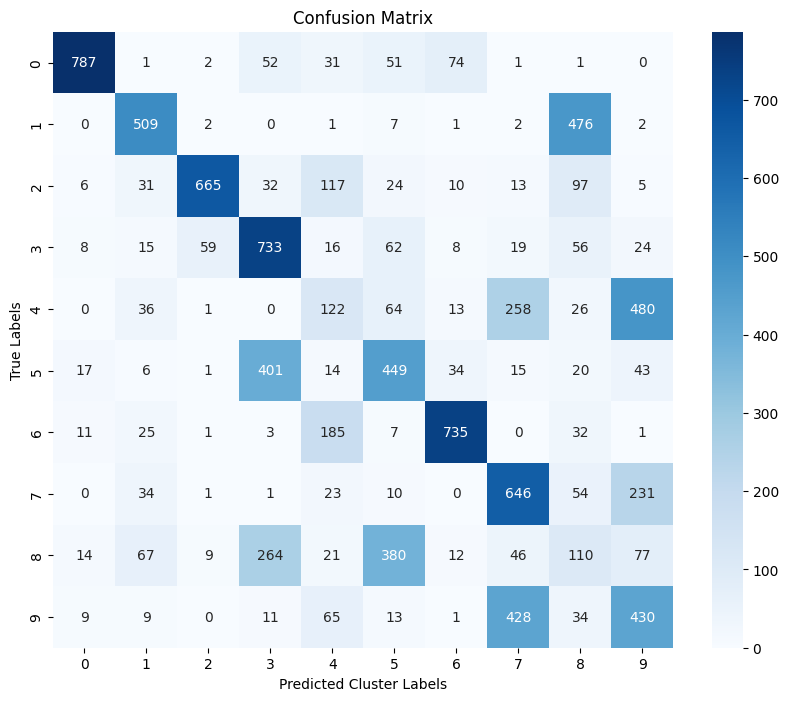

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.datasets import fetch_openml
from torch.utils.data import TensorDataset

# Load MNIST dataset using fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

# Normalize the data (MNIST data from OpenML is not normalized, so we apply this step)
X = X / 255.0  # Scale to [0, 1]

# Convert to tensor
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]
# Create tensor dataset
mnist_tensor_dataset = TensorDataset(X_tensor, torch.tensor(y, dtype=torch.long))

# Select 1000 images per class
indices = []
for label in range(10):
    class_indices = np.where(np.array(mnist_tensor_dataset.tensors[1]) == label)[0][:1000]
    indices.extend(class_indices)

# Subset the dataset
subset = Subset(mnist_tensor_dataset, indices)
dataloader = DataLoader(subset, batch_size=64, shuffle=True)

import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the autoencoder model
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, _ in dataloader:
        images = images.to(torch.float32)
        
        # Forward pass
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Collect latent representations
latent_representations = []
labels = []

with torch.no_grad():
    for images, label in dataloader:
        images = images.to(torch.float32)
        latent = autoencoder.encoder(images)
        latent_representations.append(latent.view(latent.size(0), -1))  # Flatten
        labels.extend(label)

# Concatenate all latent representations
latent_representations = torch.cat(latent_representations, dim=0).numpy()
labels = np.array(labels)

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Apply K-means
n_clusters = 10  # Number of classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_representations)

# Optionally, map cluster labels to true labels
# (e.g., use Hungarian algorithm for alignment)
# Accuracy calculation might require such alignment for evaluation.


from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score(labels, cluster_labels)
ari = adjusted_rand_score(labels, cluster_labels)

print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Map clusters to true labels using Hungarian Algorithm
from scipy.optimize import linear_sum_assignment

def remap_cluster_labels(true_labels, cluster_labels):
    n_clusters = len(np.unique(cluster_labels))
    cost_matrix = np.zeros((n_clusters, n_clusters))
    
    for i in range(n_clusters):
        for j in range(n_clusters):
            # Count instances where cluster i corresponds to true label j
            cost_matrix[i, j] = -np.sum((cluster_labels == i) & (true_labels == j))
    
    # Solve assignment problem to find the best mapping
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return col_ind

# Remap cluster labels
mapping = remap_cluster_labels(labels, cluster_labels)
aligned_labels = np.array([mapping[cluster] for cluster in cluster_labels])

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, aligned_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Cluster Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [3]:
from sklearn.metrics import confusion_matrix
import numpy as np

def compute_purity(true_labels, cluster_labels):
    """
    Compute the purity score for clustering results.
    
    :param true_labels: Ground truth labels
    :param cluster_labels: Labels assigned by clustering algorithm
    :return: Purity score (float)
    """
    conf_matrix = confusion_matrix(true_labels, cluster_labels)
    return np.sum(np.amax(conf_matrix, axis=0)) / np.sum(conf_matrix)

# Compute purity for clustering without PCA
purity = compute_purity(labels, aligned_labels)
print(f"Cluster Purity (without PCA): {purity:.4f}")

Cluster Purity (without PCA): 0.5665


Apply PCA and re run the k means clustering

Normalized Mutual Information (NMI): 0.5308
Adjusted Rand Index (ARI): 0.4113


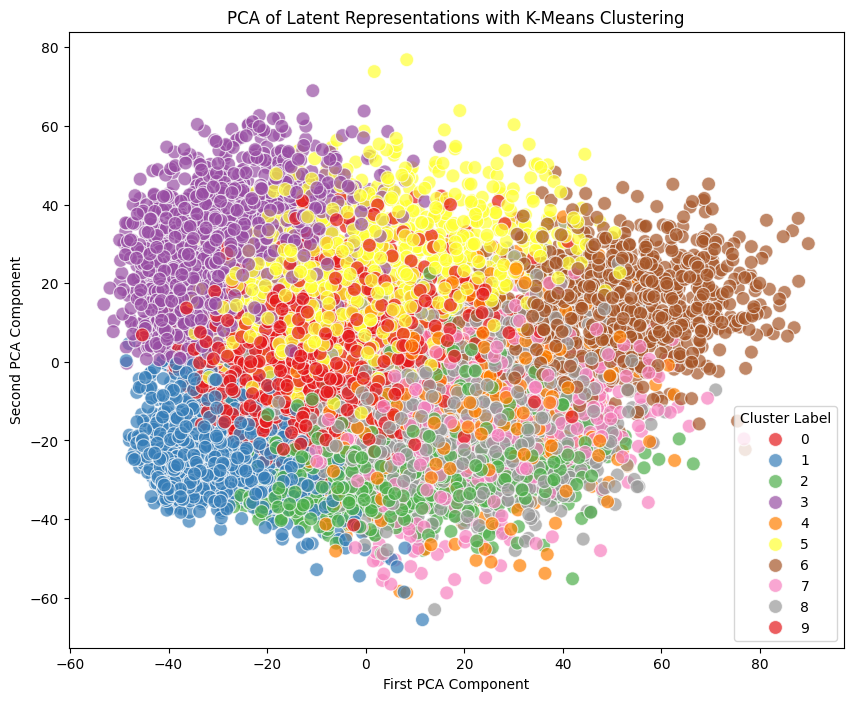

In [4]:
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Collect latent representations (latent space from the encoder)
latent_representations = []
labels = []

with torch.no_grad():
    for images, label in dataloader:
        images = images.to(torch.float32)
        latent = autoencoder.encoder(images)
        latent_representations.append(latent.view(latent.size(0), -1))  # Flatten
        labels.extend(label)

# Concatenate all latent representations
latent_representations = torch.cat(latent_representations, dim=0).numpy()
labels = np.array(labels)

# Apply PCA to reduce dimensionality
# Let's say you want to reduce the latent space to 50 dimensions, you can adjust this number
pca = PCA(n_components=60)  # Set the number of components to 50 (can be adjusted)
latent_reduced = pca.fit_transform(latent_representations)

# Apply k-means clustering on the reduced latent space
n_clusters = 10  # Number of classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_reduced)

# Evaluate clustering performance (NMI and ARI)
nmi = normalized_mutual_info_score(labels, cluster_labels)
ari = adjusted_rand_score(labels, cluster_labels)

print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Plotting the first two PCA components for visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x=latent_reduced[:, 0], y=latent_reduced[:, 1], hue=cluster_labels, palette='Set1', s=100, alpha=0.7)
plt.title('PCA of Latent Representations with K-Means Clustering')
plt.xlabel('First PCA Component')
plt.ylabel('Second PCA Component')
plt.legend(title='Cluster Label')
plt.show()

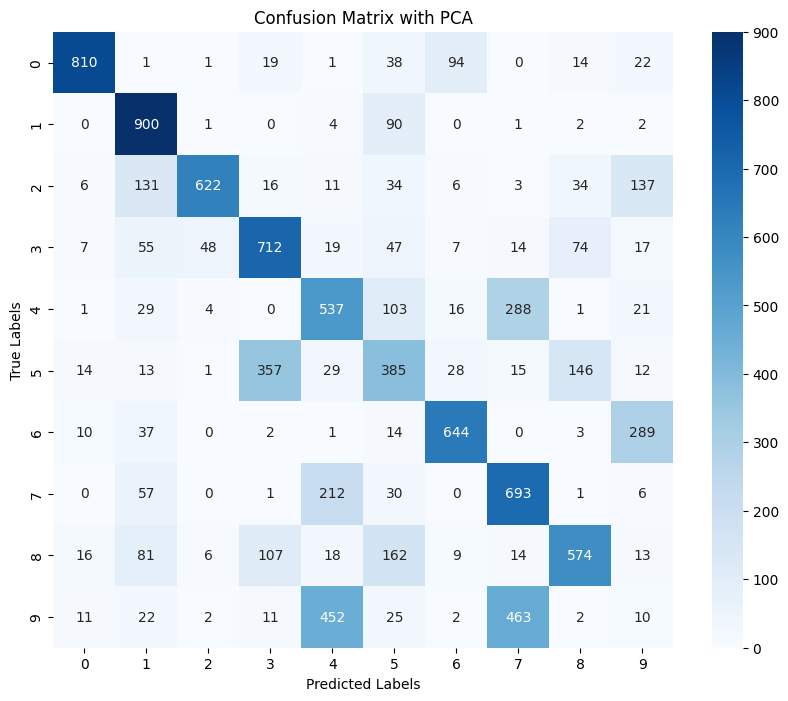

In [5]:
# Use the Hungarian Algorithm to align the clusters with true labels
# Compute the cost matrix for the Hungarian Algorithm
cost_matrix = np.zeros((10, 10))
for i in range(10):  # True labels
    for j in range(10):  # Cluster labels
        cost_matrix[i, j] = -np.sum((labels == i) & (cluster_labels == j))

# Solve the assignment problem
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Map clusters to true labels
cluster_to_label = {cluster: label for cluster, label in zip(col_ind, row_ind)}
mapped_clusters = np.array([cluster_to_label[cluster] for cluster in cluster_labels])

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, mapped_clusters)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix with PCA")
plt.show()

In [6]:
# Compute purity for clustering with PCA
purity_pca = compute_purity(labels, mapped_clusters)
print(f"Cluster Purity (with PCA): {purity_pca:.4f}")

Cluster Purity (with PCA): 0.6166
